In [1]:
import glob 
import os
import matplotlib.pyplot as plt
import pims as pm
from pims import pipeline # To analyze one frame at each time
import trackpy as tp # To do the tracking
import numpy as np
import pandas as pd

# To convert to gray scale one by one each image of the video
@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

# Tracking

In  this script, I will develop an algorith to track the particles. 

In [2]:
directory = "/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/"

filenames = [file for file in glob.glob(
    os.path.join(directory,('EXP2_2023_03_23_11_23_39_cut.avi')))]
filenames

['/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP2_2023_03_23_11_23_39_cut.avi']

# Functions and parameters used in the tracking loop

In [3]:
min_travelled_distance = -200
diameter = 13
radius = diameter/2

In [4]:
# Maybe I need to generate a file that introduce the values of the empty channel frame.  

In [5]:
def mean(video):

    frames = video[0]
    for i in range(1, len(video), 1):

        frames = frames + video[i]
        
    mean = frames/len(video)
    return mean

In [6]:
def substraction(frame, mean, video):
    """ This function substracts a frame where the channel is empty to all the particles.
        This procedure helps to enhance difference among frames and then contrast to perform the tracking."""
    
    frame_sub = (mean- video[frame].astype(np.int8))
    
    return frame_sub

In [7]:
def filtering_particles_passed_channel(df, min_travelled_distance):
    """ In this function I will filter only the particles that passed throught the channel. 
        This will be done by filtering the particles that has travelled a minimum distance."""
    
    df["l_travelled"] = df.groupby("particle")["x"].transform(lambda x: x - x.max())
    particles_in_channel = (df.groupby('particle')['l_travelled'].min() > min_travelled_distance).to_frame()
    particles_in_channel = particles_in_channel.loc[particles_in_channel.l_travelled, :]
    no_passed = particles_in_channel.index.unique()
    df = df.drop(index=no_passed, level = 1)

    return df

In [8]:
def analyze_whole_vid(video,filename):
        loc_df = []
        # The following loop perform the tracking
        mean_v = mean(video)
        for i in range(0,len(video), 1): # Analyze 1 frame each 5 frame
            #print(i)
            sub = substraction(i, mean_v, video) # change the frame where the channel is empty
            loc = tp.locate(sub,2*round(radius)+1,threshold = 0,separation = diameter/2,minmass = 300)
            loc['frame'] = i
            loc_df.append(loc.copy(deep = True))
            
        location = pd.concat(loc_df)
        location.to_csv(filename[:filename.find(".avi")]+"_location.dat", sep = "\t")

        return location

# Loop to analyze all the videos

In [9]:
@pipeline 
def locate_and_track(filename):
    
    print(filename)
    video = pm.open(filename)
    video = as_gray(video)
    print(len(video))

    location = analyze_whole_vid(video,filename)
    # Here we filter the particles that passed through the channel 

    tracking = tp.link(location,10, memory = 5, neighbor_strategy= 'KDTree') # Generate the trajectories
    tracking = tracking.set_index(["frame","particle"])
    track = filtering_particles_passed_channel(tracking, min_travelled_distance = -200)

    # Saving the data
    track.to_csv(filename[:filename.find(".avi")]+"_tracking.dat", sep="\t")
    
[locate_and_track(f) for f in filenames[:]]

Frame 3705: 99 trajectories present.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[None]

# Show trajectories of all the analyzed experiments 

In [12]:
n_rows = len(filenames)
n_rows

1

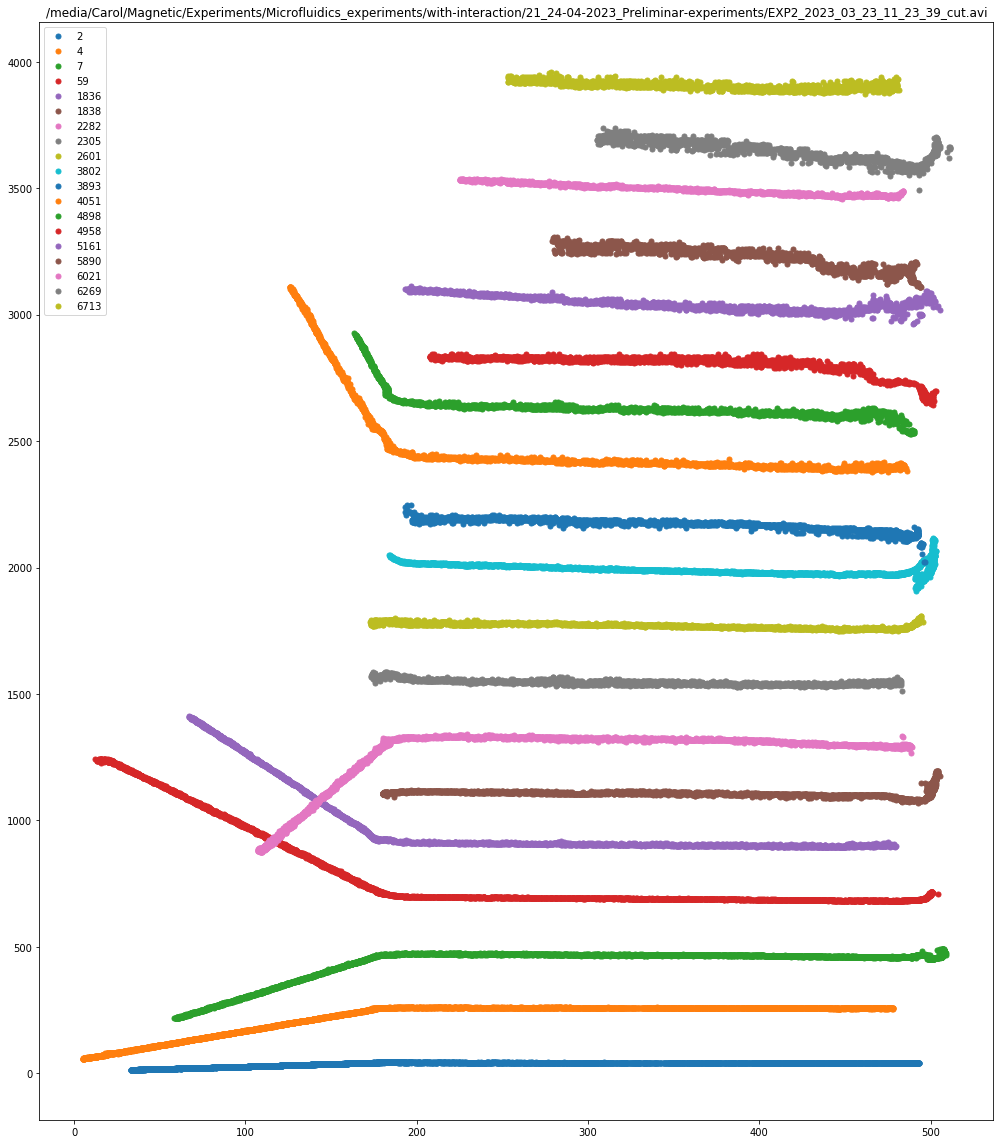

In [19]:
fig, ax = plt.subplots(int(n_rows),1,figsize=(15,16*n_rows))

i = -1
for file_no, filename in enumerate(filenames[0:]):

    trj = pd.read_csv(filename[:filename.find(".avi")]+"_tracking.dat", index_col = [0,1], sep ="\t")
        
    #video = pm.open(filename)

    #ax.flatten()[file_no].imshow(video[file_no])
    #ax.flatten()[file_no].set_axis_off()
    i = 1
    for p,trj_p in trj.groupby("particle"):
#         ax.flatten()[file_no].plot(trj_p.x, trj_p.y*0.2*i, '.', alpha = 0.1, markersize = 20)
#         ax.flatten()[file_no].set_title(str(filename))
          ax.plot(trj_p.x, trj_p.y*0.2*i, 'o', alpha = 1, markersize = 5, label = p)
          ax.set_title(str(filename))
          ax.legend()
          i =i + 5 
plt.tight_layout()

In [29]:
frame = trj.query('frame < 831')

In [78]:
frame_u = trj.query('frame == 1511')
frame_u

y           x         mass      size       ecc  \
frame particle                                                            
1511  59        217.345083  233.320688   711.083519  3.680014  0.202870   
      7         212.721217  376.885805  1060.014990  4.077974  0.187783   
      2282      210.309810  412.809720   852.230349  3.865788  0.147864   
      1836      215.057435  338.556080   761.061877  3.501409  0.082944   
      1838      207.544010  487.154124   634.664011  3.712711  0.190154   
      4         212.470270  174.649817   523.091530  3.892173  0.172303   
      2         214.535990  188.130760   613.648646  3.877193  0.032752   
      2601      213.962021  455.004373   664.009102  3.291004  0.236084   
      2305      214.428038  398.070044   757.164482  3.846612  0.251773   

                   signal     raw_mass        ep  l_travelled  
frame particle                                                 
1511  59        15.131063  1924.203321  0.067371  -270.683452  
      7         17.041550  2635.876883  0.057562  -131.865945  
      2282      15.360321  2448.500850  0.059857   -76.218053  
      1836      19.486974  1845.985093  0.068657  -140.919412  
      1838      11.921443  1339.370121  0.078341   -18.001500  
      4         10.698731  1774.513077  0.069876  -303.364153  
      2          9.858116  2187.542367  0.063375  -305.015462  
      2601      16.353775  1195.292098  0.081615   -40.790607  
      2305      15.283902  2114.102353  0.064441   -85.408167

In [82]:
frame_u.sort_values(by = 'x')

y           x         mass      size       ecc  \
frame particle                                                            
1511  4         212.470270  174.649817   523.091530  3.892173  0.172303   
      2         214.535990  188.130760   613.648646  3.877193  0.032752   
      59        217.345083  233.320688   711.083519  3.680014  0.202870   
      1836      215.057435  338.556080   761.061877  3.501409  0.082944   
      7         212.721217  376.885805  1060.014990  4.077974  0.187783   
      2305      214.428038  398.070044   757.164482  3.846612  0.251773   
      2282      210.309810  412.809720   852.230349  3.865788  0.147864   
      2601      213.962021  455.004373   664.009102  3.291004  0.236084   
      1838      207.544010  487.154124   634.664011  3.712711  0.190154   

                   signal     raw_mass        ep  l_travelled  
frame particle                                                 
1511  4         10.698731  1774.513077  0.069876  -303.364153  
      2          9.858116  2187.542367  0.063375  -305.015462  
      59        15.131063  1924.203321  0.067371  -270.683452  
      1836      19.486974  1845.985093  0.068657  -140.919412  
      7         17.041550  2635.876883  0.057562  -131.865945  
      2305      15.283902  2114.102353  0.064441   -85.408167  
      2282      15.360321  2448.500850  0.059857   -76.218053  
      2601      16.353775  1195.292098  0.081615   -40.790607  
      1838      11.921443  1339.370121  0.078341   -18.001500

No handles with labels found to put in legend.


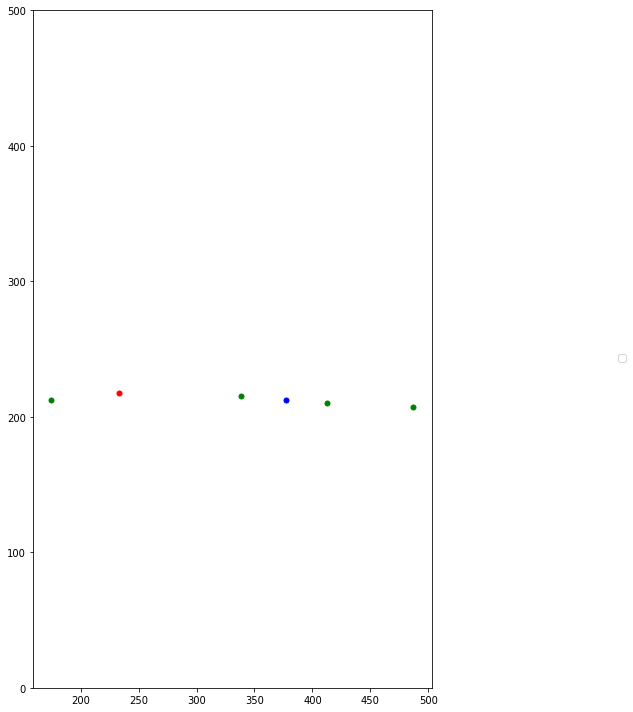

In [80]:
fig, ax = plt.subplots(1,figsize=(10,10))


ax.plot(frame_u.iloc[0].x, frame_u.iloc[0].y, 'o', alpha = 1, markersize = 5, c = 'red')
ax.plot(frame_u.iloc[1].x, frame_u.iloc[1].y, 'o', alpha = 1, markersize = 5, c = 'blue')
ax.plot(frame_u.iloc[2].x, frame_u.iloc[2].y, 'o', alpha = 1, markersize = 5, c = 'green')
ax.plot(frame_u.iloc[3].x, frame_u.iloc[3].y, 'o', alpha = 1, markersize = 5, c = 'green')
ax.plot(frame_u.iloc[4].x, frame_u.iloc[4].y, 'o', alpha = 1, markersize = 5, c = 'green')
ax.plot(frame_u.iloc[5].x, frame_u.iloc[5].y, 'o', alpha = 1, markersize = 5, c = 'green')





ax.legend( bbox_to_anchor=(1, 0., 0.5, 0.5))

plt.ylim(0,500)
plt.tight_layout()